In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import pandas as pd
import os
import opendatasets as od
import tensorflow as tf
import keras
from sklearn.utils import shuffle
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
DATASET_ENCODING = "ISO-8859-1"

In [4]:
#Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/kazanova/sentiment140?select=training.1600000.processed.noemoticon.csv'
# Using opendatasets let's download the data sets
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jazxmok
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140


100%|██████████| 80.9M/80.9M [00:00<00:00, 1.12GB/s]

In [6]:
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/sentiment140/training.1600000.processed.noemoticon.csv',encoding=DATASET_ENCODING)
df= df.iloc[:,[0,-1]]
df.columns = ['sentiment','tweet']
df = pd.concat([df.query("sentiment==0").sample(20000),df.query("sentiment==4").sample(20000)])

In [7]:
df.sentiment = df.sentiment.map({0:0,4:1})
df =  shuffle(df).reset_index(drop=True)


In [8]:
df,df_test = train_test_split(df,test_size=0.2)


In [9]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [10]:
def vectorize(df):
    embeded_tweets = embed(df['tweet'].values.tolist()).numpy()
    targets = df.sentiment.values
    return embeded_tweets,targets
embeded_tweets,targets = vectorize(df)

In [11]:
model = keras.Sequential()
model.add(tf.keras.Input(shape=(512,),dtype='float32'))
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))

model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,985 (289.00 KB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
num_epochs = 2
batch_size = 32   ## 2^x
history = model.fit(embeded_tweets,
                    targets,
                    epochs=num_epochs,
                    validation_split=0.1,
                    shuffle=True,
                    batch_size=batch_size)

Epoch 1/2
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.7441 - loss: 0.5233 - val_acc: 0.7875 - val_loss: 0.4483
Epoch 2/2
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.7898 - loss: 0.4432 - val_acc: 0.7909 - val_loss: 0.4450


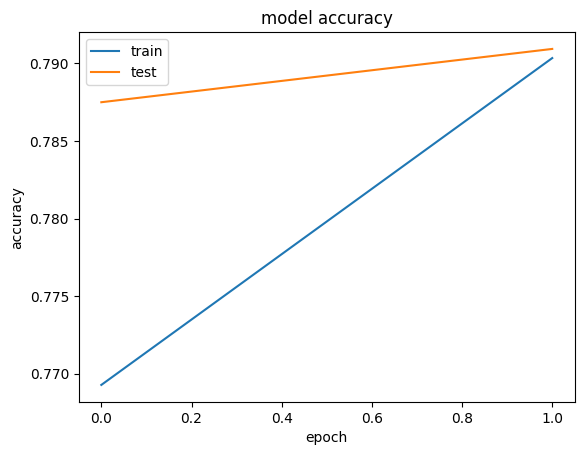

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [14]:
from sklearn.metrics import accuracy_score
embed_test,targets = vectorize(df_test)
predictions = model.predict(embed_test).astype(int)
accuracy_score(predictions,targets)*100


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


50.0125

In [15]:
def predict_sentiment(new_text):
    # Step 1: Embed the new text
    embedded_text = embed([new_text]).numpy()
    # Step 2: Make a prediction
    prediction = model.predict(embedded_text)
    # Step 3: Interpret the prediction
    sentiment = (prediction > 0.5).astype(int)  # Use 0.5 as the threshold
    return "Positive sentiment" if sentiment[0][0] == 1 else "Negative sentiment"
# Example usage:
# new_string = "I really enjoyed this product, it's fantastic!"
new_string = "this is bad"
result = predict_sentiment(new_string)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
